In [19]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = ""
assert not cira.auth.check_keys()

SYMBOL = "ETH/USD" 
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Cryptocurrency(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2021, 1, 1)
    end = datetime.now().date() 
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2021-01-01 06:00:00+00:00,ETH/USD,742.15,745.00,716.65,733.65,6534.81013,6514.0,731.807780
2021-01-02 06:00:00+00:00,ETH/USD,735.29,791.08,725.44,786.88,16071.74933,15214.0,769.787732
2021-01-03 06:00:00+00:00,ETH/USD,786.64,1098.00,784.55,1086.86,44039.92386,43031.0,942.620484
2021-01-04 06:00:00+00:00,ETH/USD,1086.86,1169.05,880.00,991.40,50778.44556,51353.0,1030.893782
2021-01-05 06:00:00+00:00,ETH/USD,992.00,1138.00,980.08,1105.56,25283.79028,26369.0,1073.661942


In [20]:
data.tail().iloc[-1]

symbol             ETH/USD
open              2626.759
high             2645.0495
low               2575.753
close            2643.9435
volume           19.427921
trade_count           49.0
vwap           2616.465356
Name: 2024-09-30 05:00:00+00:00, dtype: object

<Axes: xlabel='timestamp'>

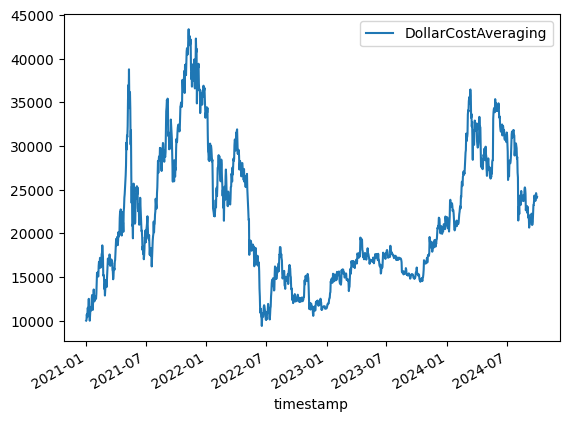

In [21]:
strat = cira.strategy.DollarCostAveraging(amount=1.1)
cira.strategy.back_test(strat, data, data["close"].to_frame(), 10_000).plot()

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [23]:
valdiation_data = data.iloc[-200:].copy()
data = data.iloc[:-200]

In [24]:
features = ['open', 'high', 'low', 'volume', 'trade_count', 'vwap']
target = 'close'

X = data[features].values
y = np.nan_to_num(data[target].pct_change().values)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [26]:
class PredictPriceNN(nn.Module):
    def __init__(self, input_dim):
        super(PredictPriceNN, self).__init__()
        self.l1 = nn.Linear(input_dim, 64)
        self.l2 = nn.Linear(64, 32)
        self.l3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.l3(x)
        return x

In [27]:
model = PredictPriceNN(input_dim=len(features))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<Axes: >

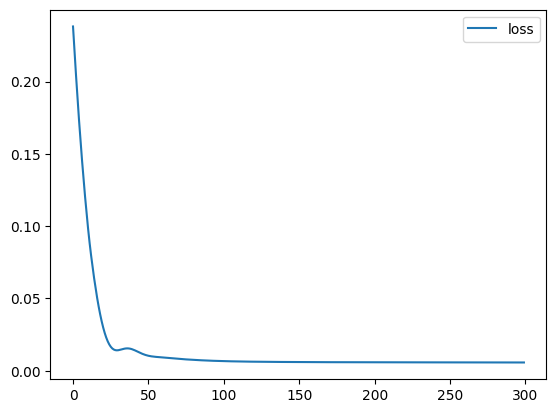

In [28]:
n_epochs = 300 
lloss = []
for epoch in range(n_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lloss.append(loss.item())
pd.DataFrame({"loss":lloss}).plot()

In [29]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0053


In [30]:
X_tensor = torch.FloatTensor(X_scaled[-5:])
pred = model(X_tensor)
pred_price = scaler_y.inverse_transform(pred.detach().numpy())
print(f"Prediction: {pred_price[-1][0]}")

Prediction: -0.00012769926979672164


In [31]:
import cira
from pandas import DataFrame
from numpy import ndarray


class NNTradingStrat(cira.strategy.Strategy):
    def __init__(self, model, scaler_X, scaler_y, risk = 0.1):
        super().__init__(name="NN")
        self.model = model
        self.risk = risk
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y
        self.allocation = []
        self.cash_balance = []
 
    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash:float)-> ndarray: 
        self.cash_balance.append(cash)
        X_scaled = self.scaler_X.fit_transform(feature_data)
        X_tensor = torch.FloatTensor(X_scaled) 
        pred = self.scaler_y.inverse_transform(self.model(X_tensor).detach().numpy())[-1][0]
        _price = prices.values[-1][0]
        action = [0]        
        if pred > 0.0: 
            action[0] = float(_price / (cash * self.risk ))
        elif pred < 0.0: 
            action[0] = -1 * float(portfolio[-1]) * self.risk 
        self.allocation += action 
        return np.array(action)

In [32]:

X_vali = valdiation_data[features]
prices = valdiation_data[target].to_frame()

<Axes: xlabel='timestamp'>

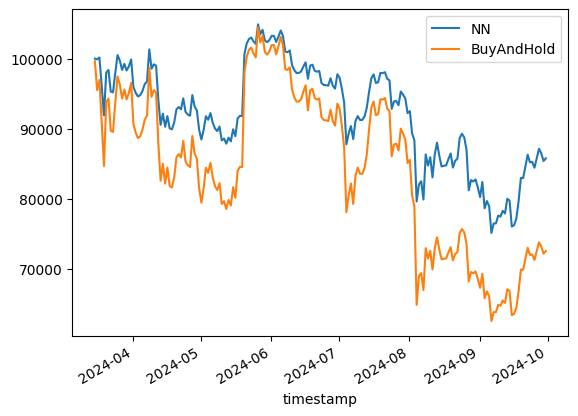

In [33]:
strat = NNTradingStrat(model, scaler_X, scaler_y, risk=0.005)
cira.strategy.back_test_against_buy_and_hold(strat, X_vali, prices, 100_000).plot()

<Axes: >

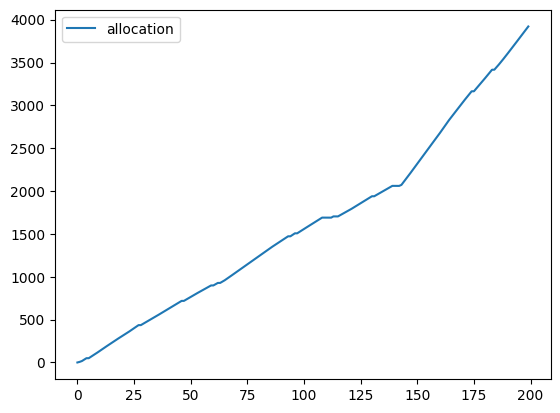

In [34]:

pd.DataFrame({"allocation":np.array(strat.allocation).cumsum()}).plot()

<Axes: >

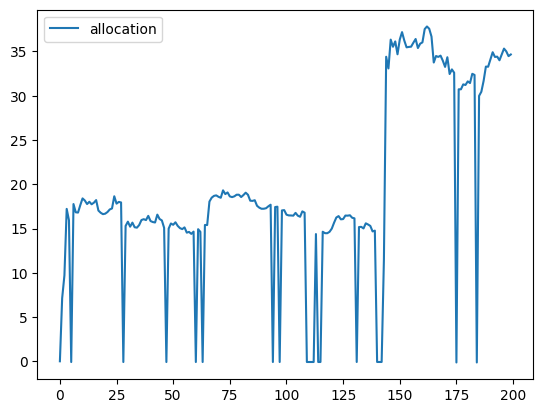

In [35]:

pd.DataFrame({"allocation":np.array(strat.allocation)}).plot()

<Axes: >

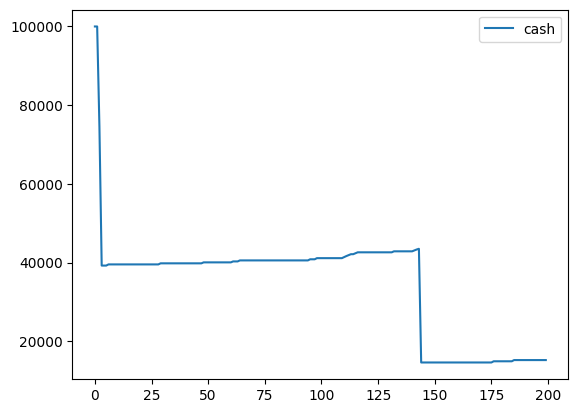

In [36]:
pd.DataFrame({"cash":np.array(strat.cash_balance)}).plot()